# Plotting Single Starlink Trajectory:

In [5]:
# Imports:
from skyfield.api import EarthSatellite, load
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def trajectory(tle, array_of_epochs):
    """
    Compute satellite trajectory's Cartesian coordinates
    in three dimensions from USSPACECOM TLE using SGP4.

    Parameters:
    ----------
    tle : str
        two-line element.
    array_of_epochs : array
        array of epoch times to calculate coordinates at.

    Returns:
    ----------
    x, y, z : tuple
        Cartesian coordinates of satellite positions at 
        each epoch.
    """
    # Load TLE:
    L1, L2 = tle.splitlines()
    # Calculate Trajectory across Epochs:
    starlink = EarthSatellite(L1, L2)  # load SGP4
    position = starlink.at(array_of_epochs).position.km  # run SGP4
    x = position[0, :]
    y = position[1, :]
    z = position[2, :]

    return x, y, z

In [7]:
def plot_satellite(satellite_tle, elev, azim, time):
    """
    Plot satellite trajectory around 3D model of Earth, 
    at observer's elevation and azimuthal angle.

    Parameters:
    ----------
    satellite_tle : str
        two-line element.
    elev : float
        observer's elevation from 3-D earth model (deg).
    azim : float
        observer's elevation from 3-D earth model (deg).
    time : array
        array of epoch times.
    """

    # 3D Earth model:
    re = 6378 # km
    halfpi, pi, twopi = [f * np.pi for f in [0.5, 1, 2]]
    degs, rads = 180 / pi, pi / 180
    theta = np.linspace(0, twopi, 201)
    cth, sth, zth = [f(theta) for f in [np.cos, np.sin, np.zeros_like]]
    lon0 = re * np.vstack((cth, zth, sth))
    lons = []
    for phi in rads * np.arange(0, 180, 15):
        cph, sph = [f(phi) for f in [np.cos, np.sin]]
        lon = np.vstack(
            (lon0[0] * cph - lon0[1] * sph, lon0[1] * cph + lon0[0] * sph, lon0[2])
        )
        lons.append(lon)

    lats = []
    for phi in rads * np.arange(-75, 90, 15):
        cph, sph = [f(phi) for f in [np.cos, np.sin]]
        lat = re * np.vstack((cth * cph, sth * cph, zth + sph))
        lats.append(lat)

    # Plotting Satellite Orbits:
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1, projection="3d")

    sat_norad = str(satellite_tle)[2:7]
    x_sat, y_sat, z_sat = trajectory(satellite_tle, time)
    ax.plot(x_sat, y_sat, z_sat, label=f"{sat_norad}", color="deeppink")

    # Plotting latitude/longitude lines:
    for x, y, z in lons:
        ax.plot(x, y, z, "-k")
    for x, y, z in lats:
        ax.plot(x, y, z, "-k")

    # Plotting parameters:
    ax.view_init(elev, azim)
    ax.set_title(
        f"""NORAD ID {sat_norad} Trajectory:
        \n(elev={elev}$\degree$, azim={azim}$\degree$)"""
    )
    ax.set_xlabel("x (km)"), ax.set_ylabel("y (km)"), ax.set_zlabel("z (km)")
    ax.legend(loc="best")
    plt.show()

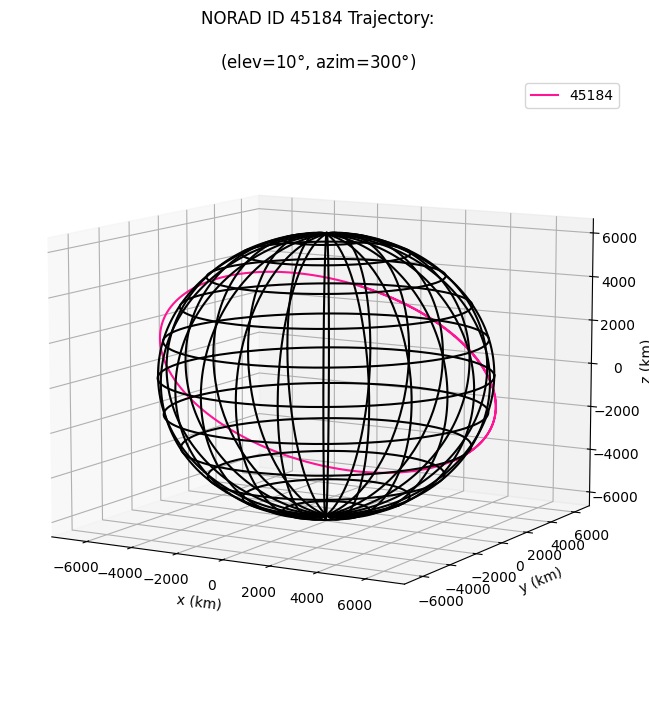

In [8]:
# TLE:
tle = """1 45184U 20012G   25064.25002315  .00356607  59443-4  10540-2 0  9990
2 45184  53.0352 192.9089 0003887 301.4292 249.9972 15.92081662279489"""

# Define Orbit Epochs:
ts = load.timescale()
orbit_duration = np.arange(0, 7201, 1)  # orbit duration in seconds
epochs_of_orbit = ts.utc(
    2025, 3, 5, 22, 15, 0 + orbit_duration
)  # add duration to initial epoch

# Create Plot:
plot_satellite(tle, 10, 300, epochs_of_orbit)